In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.5 MB/s eta 0:00:00


In [2]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

### Functions

In [4]:
# function to get the average probability of the next correct token given a
# dataframe containing text samples
def get_probabilites(df_examples):
  probabilities_per_length = {}
  for ind, row in df_examples.iterrows():
    ex = row["example"]
    encoding = tokenizer(ex, return_tensors="pt")
    encoding_length = len(encoding["input_ids"][0, :])
    for i in range(0, encoding_length - 1):
      context_tokens = encoding["input_ids"][:, 0:i+1]
      context_attention_mask = encoding["attention_mask"][:, 0:i+1]
      with torch.inference_mode():
        output = model(input_ids = context_tokens, attention_mask = context_attention_mask)
      correct_next_token = encoding["input_ids"][:, i+1]
      logits = output.logits[0, -1, :]
      probabilities = torch.softmax(logits, -1)
      prob_correct_token = probabilities[correct_next_token]
      if i+1 in probabilities_per_length:
        probabilities_per_length[i+1].append(prob_correct_token)
      else:
        probabilities_per_length[i+1] = [prob_correct_token]
  return probabilities_per_length

In [30]:
# function to get the probability of the next correct token for one example
# it shows the context and probability for each context length and visualizes
# the probabilities
def see_example(example):
  plt.figure(figsize=(5, 3))
  encoding = tokenizer(example, return_tensors="pt")
  encoding_length = len(encoding["input_ids"][0, :])
  x = np.arange(1, encoding_length)
  y = np.zeros(encoding_length - 1)
  for i in range(0, encoding_length - 1):
    context_tokens = encoding["input_ids"][:, 0:i+1]
    context_attention_mask = encoding["attention_mask"][:, 0:i+1]
    with torch.inference_mode():
      output = model(input_ids = context_tokens, attention_mask = context_attention_mask)
    correct_next_token = encoding["input_ids"][:, i+1]
    logits = output.logits[0, -1, :]
    probabilities = torch.softmax(logits, -1)
    prob_correct_token = probabilities[correct_next_token]
    y[i] = prob_correct_token
    print(''.join([tokenizer.decode(token) for token in context_tokens[0, :]]), " | ", prob_correct_token)
    plt.scatter(x, y, s=3, c='blue')
    plt.title("Accuracy as a function of context length")
    plt.xlabel("Length of context")
    plt.ylabel("Probability of the next correct token")

In [25]:
# visualize the average probability trend
# the input to this function is the output of get_probabilities(data)
def plot_average(result):
  x = np.zeros(len(result))
  y = np.zeros(len(result))
  t = np.zeros(len(result))
  for key, value in result.items():
    x[key - 1] = key
    y[key - 1] = (sum(value)/len(value))
    t[key - 1] = len(value)
  plt.scatter(x, y, s=3, c=t)
  plt.title("Accuracy as a function of context length")
  plt.xlabel("Length of context")
  plt.ylabel("Average probability of predicting the correct next token")
  plt.colorbar()

### Individual examples

O  |  tensor([0.0005])
Oat  |  tensor([2.7226e-05])
Oat milk  |  tensor([0.0113])
Oat milk has  |  tensor([0.1467])
Oat milk has a  |  tensor([0.0017])
Oat milk has a creamy  |  tensor([0.4626])
Oat milk has a creamy texture  |  tensor([0.2969])
Oat milk has a creamy texture and  |  tensor([0.0027])
Oat milk has a creamy texture and mild  |  tensor([0.0007])
Oat milk has a creamy texture and mild o  |  tensor([0.0985])
Oat milk has a creamy texture and mild oatmeal  |  tensor([0.0239])
Oat milk has a creamy texture and mild oatmeal-  |  tensor([0.8182])
Oat milk has a creamy texture and mild oatmeal-like  |  tensor([0.3809])
Oat milk has a creamy texture and mild oatmeal-like flavor  |  tensor([1.6138e-05])
Oat milk has a creamy texture and mild oatmeal-like flavor,[  |  tensor([0.0572])
Oat milk has a creamy texture and mild oatmeal-like flavor,[3  |  tensor([0.8540])
Oat milk has a creamy texture and mild oatmeal-like flavor,[3]  |  tensor([0.1864])
Oat milk has a creamy texture and 

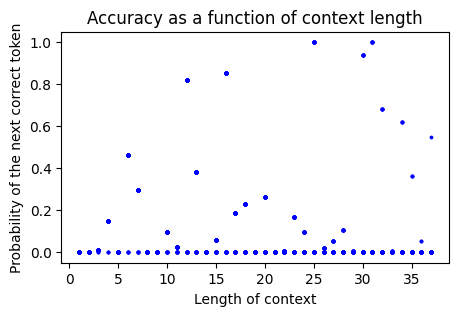

In [31]:
#https://en.wikipedia.org/wiki/Oat_milk
example = "Oat milk has a creamy texture and mild oatmeal-like flavor,[3] and is manufactured in various flavors, such as sweetened, unsweetened, vanilla, and chocolate."
see_example(example)

As  |  tensor([0.0063])
As an  |  tensor([0.0009])
As an intellectual  |  tensor([0.0036])
As an intellectual object  |  tensor([0.5586])
As an intellectual object,  |  tensor([0.0342])
As an intellectual object, a  |  tensor([0.0156])
As an intellectual object, a book  |  tensor([0.2571])
As an intellectual object, a book is  |  tensor([9.8207e-07])
As an intellectual object, a book is prototyp  |  tensor([0.0514])
As an intellectual object, a book is prototypically  |  tensor([0.3625])
As an intellectual object, a book is prototypically a  |  tensor([0.0010])
As an intellectual object, a book is prototypically a composition  |  tensor([0.3521])
As an intellectual object, a book is prototypically a composition of  |  tensor([0.0008])
As an intellectual object, a book is prototypically a composition of such  |  tensor([0.0009])
As an intellectual object, a book is prototypically a composition of such great  |  tensor([0.0011])
As an intellectual object, a book is prototypically a compo

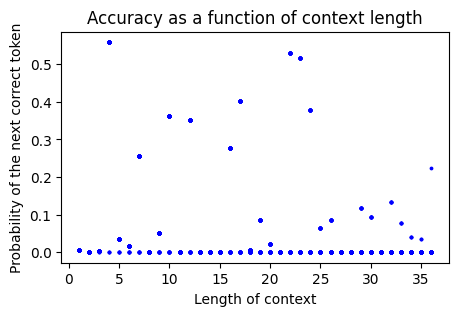

In [32]:
#https://en.wikipedia.org/wiki/Book
example = "As an intellectual object, a book is prototypically a composition of such great length that it takes a considerable investment of time to compose and still considered as an investment of time to read."
see_example(example)

Photos  |  tensor([1.9360e-06])
Photosynthesis  |  tensor([0.1094])
Photosynthesis is  |  tensor([0.1531])
Photosynthesis is a  |  tensor([0.0027])
Photosynthesis is a biological  |  tensor([0.9639])
Photosynthesis is a biological process  |  tensor([0.0029])
Photosynthesis is a biological process used  |  tensor([0.1032])
Photosynthesis is a biological process used by  |  tensor([0.0648])
Photosynthesis is a biological process used by many  |  tensor([0.0001])
Photosynthesis is a biological process used by many cellular  |  tensor([0.4477])
Photosynthesis is a biological process used by many cellular organisms  |  tensor([0.5368])
Photosynthesis is a biological process used by many cellular organisms to  |  tensor([0.0290])
Photosynthesis is a biological process used by many cellular organisms to convert  |  tensor([0.0142])
Photosynthesis is a biological process used by many cellular organisms to convert light  |  tensor([0.0305])
Photosynthesis is a biological process used by many c

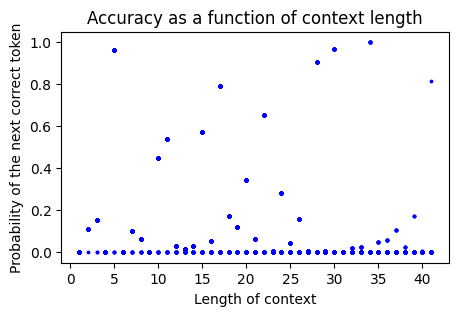

In [41]:
"https://en.wikipedia.org/wiki/Photosynthesis"
example = "Photosynthesis is a biological process used by many cellular organisms to convert light energy into chemical energy, which is stored in organic compounds that can later be metabolized through cellular respiration to fuel the organism's activities."
see_example(example)

### Average over multiple examples

In [43]:
data = pd.read_csv("test_data.csv")
data

,example,link
0,Photosynthesis is a biological process used by...,https://en.wikipedia.org/wiki/Photosynthesis
1,Oat milk is a plant milk derived from whole oa...,https://en.wikipedia.org/wiki/Oat_milk
2,Plants are the eukaryotes that form the kingdo...,https://en.wikipedia.org/wiki/Plant
3,The food system has significant impacts on a w...,https://en.wikipedia.org/wiki/Food
4,"Grain, fruit, and vegetables are basic human f...",https://en.wikipedia.org/wiki/Plant
5,"A developed country, Canada has one of the hig...",https://en.wikipedia.org/wiki/Canada
6,Caterpillars of most species eat plant materia...,https://en.wikipedia.org/wiki/Caterpillar
7,"Human food can be classified in various ways, ...",https://en.wikipedia.org/wiki/Food
8,The appearance of a caterpillar can often repe...,https://en.wikipedia.org/wiki/Caterpillar
9,The use of oil lamps began thousands of years ...,https://en.wikipedia.org/wiki/Oil_lamp


In [44]:
result = get_probabilites(data)

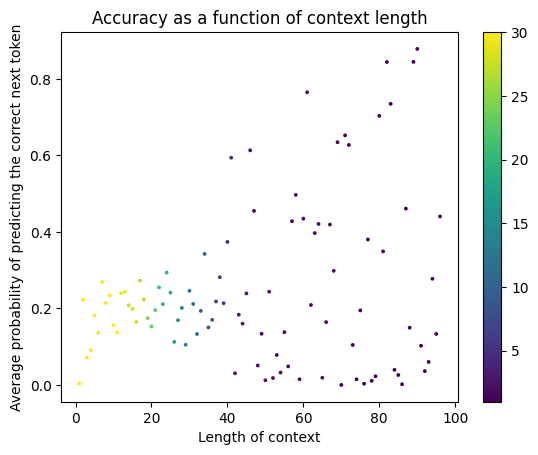

In [45]:
# colour bar shows how many examples had that context length
plot_average(result)